# 注意力汇聚： Nadaraya-Watson 核回归

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
# 生成数据集
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

# 真实的函数
def f(x):
    return 2 * torch.sin(x) + x**0.8

# 拟合函数

# 训练label是在真实函数上加上噪音
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))

# 给定test来预测函数，test = key
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

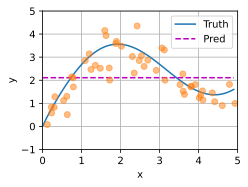

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y',
             legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚(pooling)
好处：不需要学习，只要给足够多的数据，就能还原出模型

Nadaraya-Watson核回归的公式如下：

$$ \begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split} $$

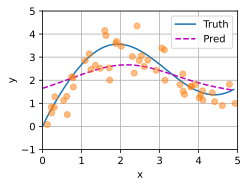

In [7]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# 给定x进来，找跟truth比较近的点，赋予大一点的权重。然后做加权平均。
# 做平滑的加权平均，但不太适合用此案列（过于平滑）
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

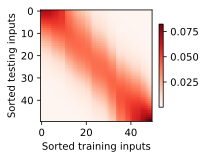

In [8]:
# 画注意力权重
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs'
    )
# 任何一行表示第i个测试样本里，key-value pair中xi的权重
# 现在来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 
# 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 
# 注意力汇聚的注意力权重就越高。

带参数注意力汇聚 假定两个张量的形状分别是(n, a, b)和(n, b, c)，它们的批量矩阵乘法输出的形状为(n, a, c)

In [11]:
# n = 2
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
# bmm batch的矩阵乘法
# batch size = 2
# 第i个（1，4）与第i个（4，6）做矩阵乘法
# [1, 4] * [4, 6] = 1*4
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [13]:
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [14]:
# 带参数的注意力平均
# 把刚刚的东西加一个w进来
# w控制高斯核窗口大小，控制平滑/不平滑
# 通过学习w使得曲线歪点还是不歪
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [15]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

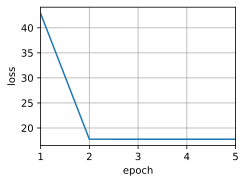

In [16]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

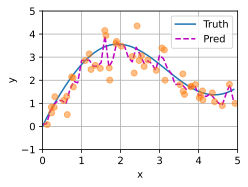

In [17]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

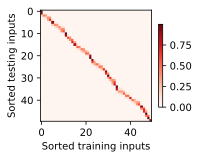

In [18]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

说明w使窗口变窄。给对应样本分的权重比较集中。

只给了距离近的权重大，放在对应的位置大权重。 

通过学习w使用注意力权重训练得更好，拟合的更加好 